In [106]:
import numpy as np
import pandas as pd
import rustworkx as rx
import networkx as nx
import matplotlib.pyplot as plt
import ipywidgets as widgets
from sklearn.cluster import KMeans
from IPython.display import display

In [107]:
def draw_graph(A:np.ndarray, group_labels=None):
    n = A.shape[0]
    G = nx.from_numpy_array(A, create_using=nx.Graph)
    pos = nx.spring_layout(G)
    plt.figure(figsize=(6, 6))
    if group_labels is None:
        nx.draw(G, pos=pos, with_labels=False, node_color="lightblue", edge_color="black")
    else:
        unique_groups = list(set(group_labels))
        colors = plt.cm.get_cmap("tab10", len(unique_groups))
        color_map = {group: colors(i) for i, group in enumerate(unique_groups)}
        node_colors = [color_map[group_labels[node]] for node in G.nodes]
        print(node_colors)
        nx.draw(G, pos=pos, with_labels=False, node_color=node_colors, edge_color="black")

# graph structure

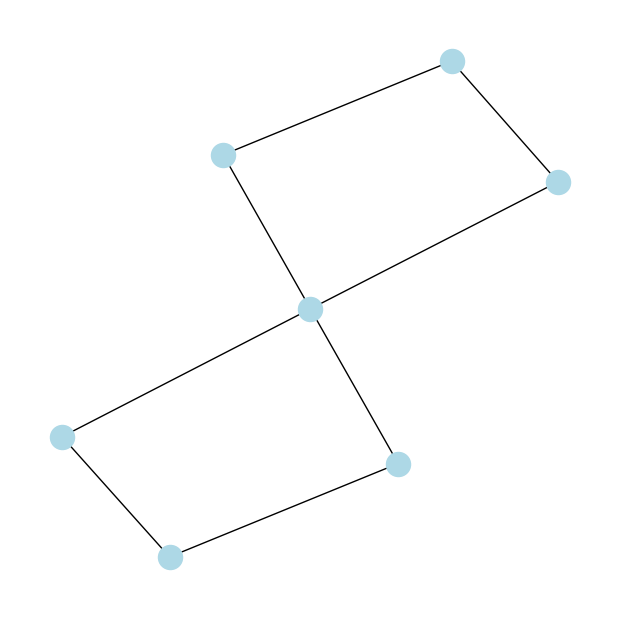

In [108]:
k = 2

AL = {
    0: [1,3],
    1: [0,2],
    2: [1,3],
    3: [0,2,4,6],
    4: [3,5],
    5: [4,6],
    6: [3,5],
}

# Get the adjacency matrix as a NumPy array
G = nx.from_dict_of_lists(AL)
A = nx.to_numpy_array(G)
D = np.diag(np.sum(A, axis=0)) #find the degree of each node
m, n = A.shape
draw_graph(A)

In [114]:
print(L_ABS)

[[2. 1. 0. 1. 0. 0. 0.]
 [1. 2. 1. 0. 0. 0. 0.]
 [0. 1. 2. 1. 0. 0. 0.]
 [1. 0. 1. 4. 1. 0. 1.]
 [0. 0. 0. 1. 2. 1. 0.]
 [0. 0. 0. 0. 1. 2. 1.]
 [0. 0. 0. 1. 0. 1. 2.]]


# Doing an SVD decomposition on the |L|= D + A

In [110]:
L_ABS = D + A
U, S, V = np.linalg.svd(L_ABS)
S = np.diag(S)
U_k = U[:,0:k]
S_k = S[0:k,0:k]
V_k = V[0:k,:]

# Compute cosine matrix

In [111]:
CM = np.zeros((m,n))
vectors = S_k @ V_k
for i in range(0,vectors.shape[1]):
    for j in range(i+1, vectors.shape[1]):
        u = vectors[:,i]
        v = vectors[:,j]
        cosine = np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))
        CM[i,j] = cosine
        CM[j,i] = cosine
np.fill_diagonal(CM, 1)

print(CM)

[[ 1.          0.91354747  1.          0.78311587  0.22654092 -0.18920188
   0.22654092]
 [ 0.91354747  1.          0.91354747  0.46247664 -0.18920188 -0.57223071
  -0.18920188]
 [ 1.          0.91354747  1.          0.78311587  0.22654092 -0.18920188
   0.22654092]
 [ 0.78311587  0.46247664  0.78311587  1.          0.78311587  0.46247664
   0.78311587]
 [ 0.22654092 -0.18920188  0.22654092  0.78311587  1.          0.91354747
   1.        ]
 [-0.18920188 -0.57223071 -0.18920188  0.46247664  0.91354747  1.
   0.91354747]
 [ 0.22654092 -0.18920188  0.22654092  0.78311587  1.          0.91354747
   1.        ]]


# Reorder cosine matrix

In [112]:
INDEX = [] # global reordering index
CM_COPY = CM.copy()
indices = list(range(0,CM.shape[1]))
while(len(indices) > 1):
    # sort by cosine similarity
    similarity_list = CM_COPY[0,:]
    new_indices = np.argsort(similarity_list)[::-1]
    
    # rearrange matrix
    indices = [indices[i] for i in new_indices]
    CM_COPY = CM_COPY[np.ix_(new_indices,new_indices)]

    # remove and update
    INDEX.append(indices[0])
    indices.pop(0)
    CM_COPY = CM_COPY[1:,1:]
INDEX.append(indices[0])
del CM_COPY
print(INDEX)
CM_REORDERED = CM[np.ix_(INDEX, INDEX)]
CM_REORDERED

# this only mismatches the paper's example because vertex 2 is exactly similar to vertex 0 so their ordering doesnt matter

[2, 0, 1, 3, 4, 6, 5]


array([[ 1.        ,  1.        ,  0.91354747,  0.78311587,  0.22654092,
         0.22654092, -0.18920188],
       [ 1.        ,  1.        ,  0.91354747,  0.78311587,  0.22654092,
         0.22654092, -0.18920188],
       [ 0.91354747,  0.91354747,  1.        ,  0.46247664, -0.18920188,
        -0.18920188, -0.57223071],
       [ 0.78311587,  0.78311587,  0.46247664,  1.        ,  0.78311587,
         0.78311587,  0.46247664],
       [ 0.22654092,  0.22654092, -0.18920188,  0.78311587,  1.        ,
         1.        ,  0.91354747],
       [ 0.22654092,  0.22654092, -0.18920188,  0.78311587,  1.        ,
         1.        ,  0.91354747],
       [-0.18920188, -0.18920188, -0.57223071,  0.46247664,  0.91354747,
         0.91354747,  1.        ]])

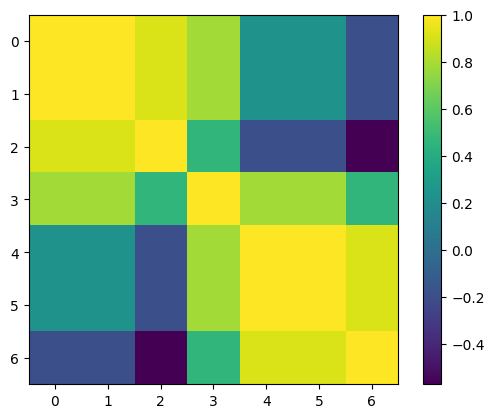

In [113]:
import matplotlib.pyplot as plt

plt.imshow(CM_REORDERED, cmap='viridis')
plt.colorbar()
plt.show()